In [ ]:
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1 — Go up one level (from /notebooks/bank_reviews → project_root)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

print("Added path:", project_root)

# Step 2 — now imports work
import pandas as pd
import psycopg2
from config.db_config import get_connection
from Scripts.load_data import load_reviews   
import server


Added path: c:\Users\Birhanu Matebe\Downloads\KAIM\WebScraper


In [4]:
server.main()

Tables 'banks' and 'reviews' created successfully!
Inserted 3 rows into banks table.
Inserted 1200 reviews.
Skipped 0 reviews due to unknown bank.


## Load Review from postgreSQl database

In [6]:

df = load_reviews()
df.head()


C:\Users\Birhanu Matebe\AppData\Local\Temp\ipykernel_15224\3541621502.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,review_id,review_text,rating,review_date,sentiment_label,sentiment_score,theme,source,bank_name,app_name
0,1,bad exprience...it is so crushed,1.0,2025-11-27,NEGATIVE,1.0,Other,Google Play,Abyssinia,BoA Mobile
1,2,not user friendly at all it requires a huge co...,1.0,2025-11-26,NEGATIVE,1.0,Account Access Issues,Google Play,Abyssinia,BoA Mobile
2,3,most of the time is not working properly,1.0,2025-11-25,NEGATIVE,1.0,Account Access Issues,Google Play,Abyssinia,BoA Mobile
3,4,It keeps notifying me to disable developer opt...,1.0,2025-11-22,NEGATIVE,1.0,Account Access Issues,Google Play,Abyssinia,BoA Mobile
4,5,the lag is unbelievable when you need it the m...,1.0,2025-11-19,NEGATIVE,1.0,Feature Requests / General Satisfaction,Google Play,Abyssinia,BoA Mobile


In [7]:
# Convert dates
df['review_date'] = pd.to_datetime(df['review_date'])
df['month'] = df['review_date'].dt.to_period('M')

# Split themes if multiple per review (optional)
df['themes'] = df['theme'].fillna('').apply(lambda x: x.split(',') if x else [])
df_theme = df.explode('themes')
df_theme = df_theme[df_theme['themes'] != '']


In [9]:
# Aggregate sentiment by bank
sentiment_by_bank = df.groupby('bank_name').agg(
    avg_sentiment=('sentiment_score', 'mean'),
    pct_positive=('sentiment_label', lambda x: (x=='POSITIVE').mean()),
    pct_negative=('sentiment_label', lambda x: (x=='NEGATIVE').mean()),
    avg_rating=('rating', 'mean'),
    review_count=('review_id','count')
)

print(sentiment_by_bank)


                             avg_sentiment  pct_positive  pct_negative  \
bank_name                                                                
Abyssinia                         0.987025         0.275         0.725   
Commercial Bank of Ethiopia       0.986575         0.550         0.450   
Dashen Bank                       0.990700         0.680         0.320   

                             avg_rating  review_count  
bank_name                                              
Abyssinia                        2.3700           400  
Commercial Bank of Ethiopia      3.7425           400  
Dashen Bank                      3.9775           400  


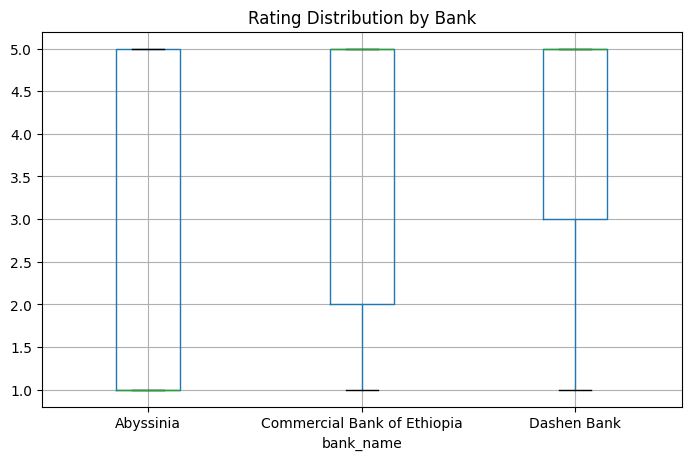

In [ ]:


df.boxplot(column='rating', by='bank_name', figsize=(8,5))
plt.title('Rating Distribution by Bank')
plt.suptitle('')
plt.show()


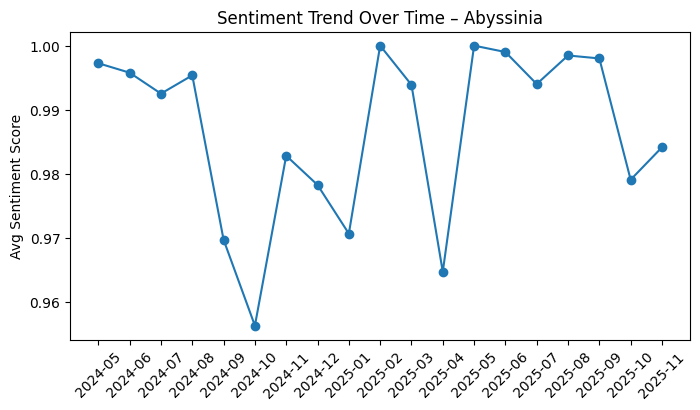

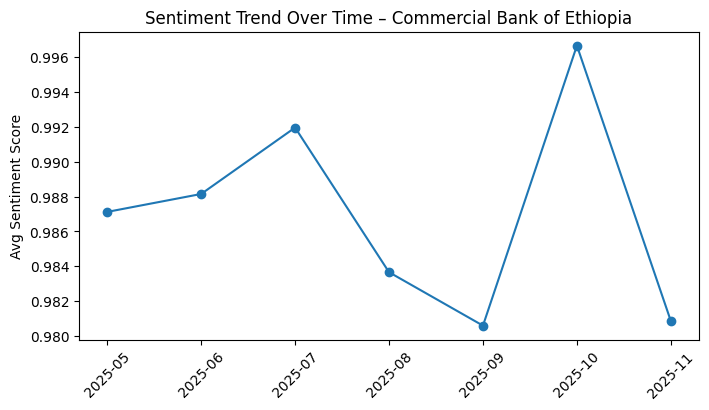

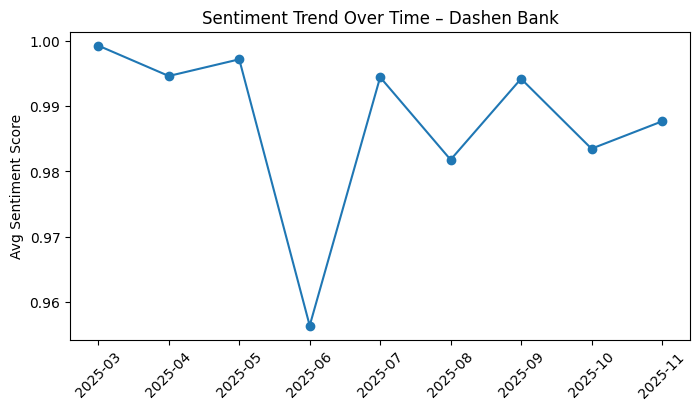

In [12]:
trend = df.groupby(['bank_name','month']).agg(avg_sentiment=('sentiment_score','mean')).reset_index()

for bank in trend['bank_name'].unique():
    temp = trend[trend['bank_name']==bank]
    plt.figure(figsize=(8,4))
    plt.plot(temp['month'].astype(str), temp['avg_sentiment'], marker='o')
    plt.title(f'Sentiment Trend Over Time – {bank}')
    plt.xticks(rotation=45)
    plt.ylabel('Avg Sentiment Score')
    plt.show()


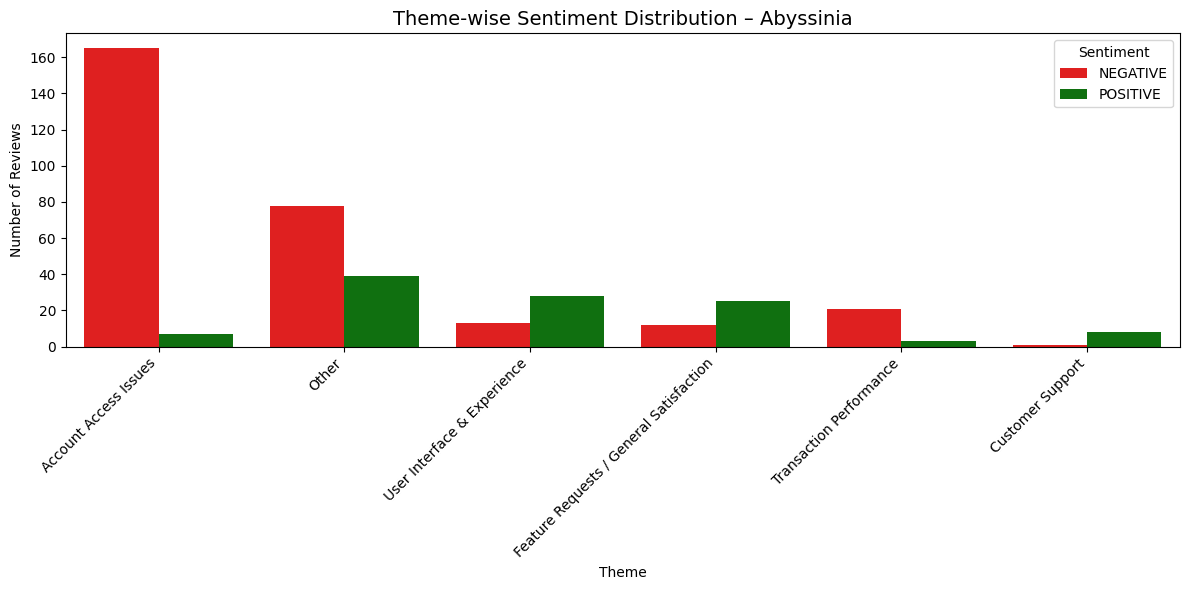

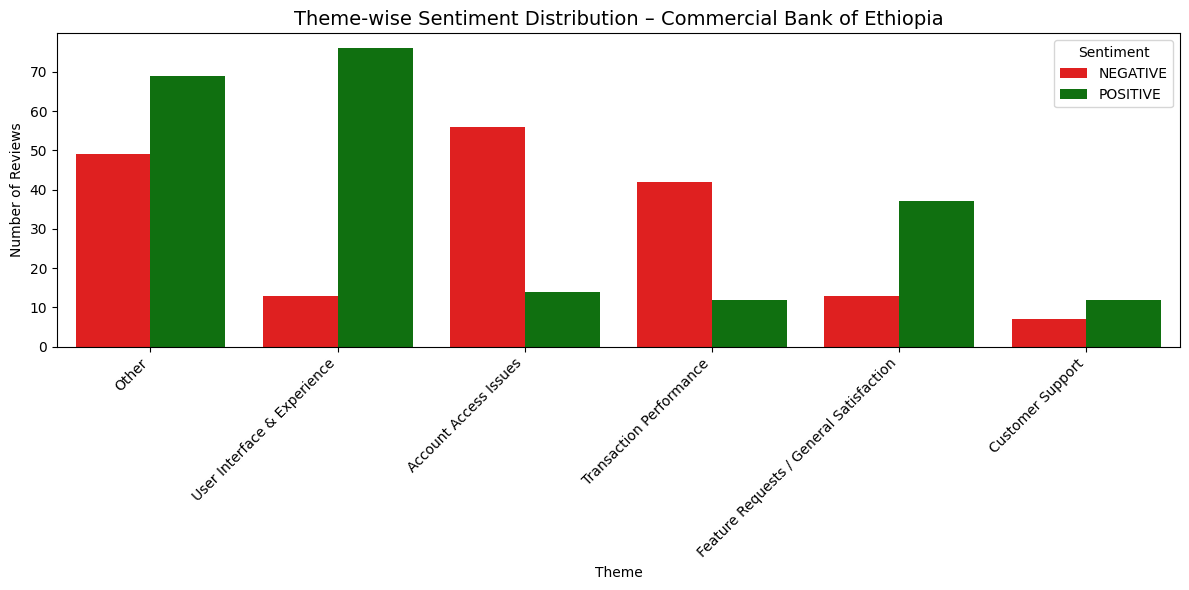

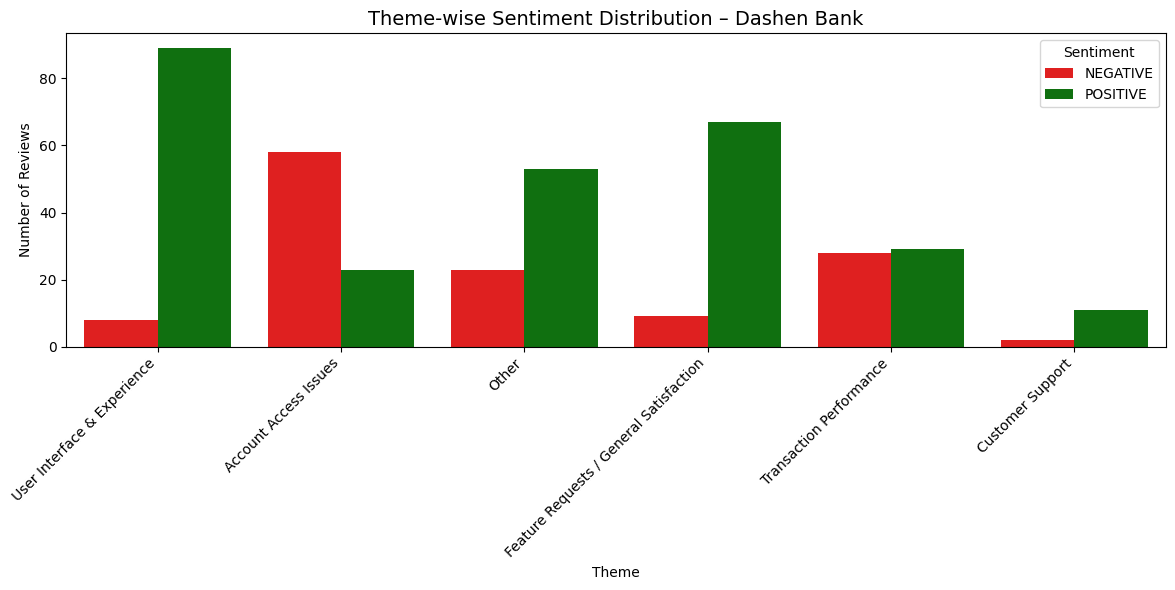

In [21]:
df['review_date'] = pd.to_datetime(df['review_date'])
df['month'] = df['review_date'].dt.to_period('M')

# Explode multiple themes per review
df['themes'] = df['theme'].fillna('').apply(lambda x: x.split(',') if x else [])
df_theme = df.explode('themes')
df_theme = df_theme[df_theme['themes'] != '']  # remove empty themes

# -------------------------------
# 3️⃣ Aggregate theme counts by sentiment
# -------------------------------
theme_sentiment_counts = df_theme.groupby(
    ['bank_name', 'themes', 'sentiment_label']
).size().reset_index(name='count')

theme_sentiment_counts = theme_sentiment_counts.rename(columns={'themes': 'theme'})
theme_sentiment_counts['sentiment_label'] = theme_sentiment_counts['sentiment_label'].str.upper()

# -------------------------------
# 4️⃣ Plot theme-wise sentiment per bank
# -------------------------------
palette = {'POSITIVE': 'green', 'NEGATIVE': 'red', 'NEUTRAL': 'gray'}

for bank in df['bank_name'].unique():
    plt.figure(figsize=(12, 6))
    bank_data = theme_sentiment_counts[theme_sentiment_counts['bank_name'] == bank]
    
    # Sort themes by total count
    theme_order = bank_data.groupby('theme')['count'].sum().sort_values(ascending=False).index

    sns.barplot(
        data=bank_data,
        x='theme',
        y='count',
        hue='sentiment_label',
        palette=palette,
        order=theme_order
    )
    
    plt.title(f"Theme-wise Sentiment Distribution – {bank}", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Number of Reviews")
    plt.xlabel("Theme")
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()



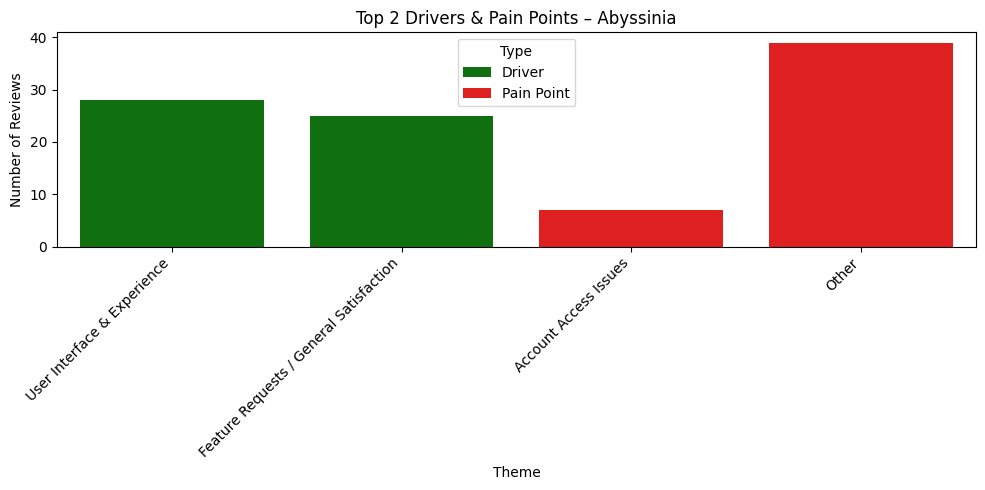

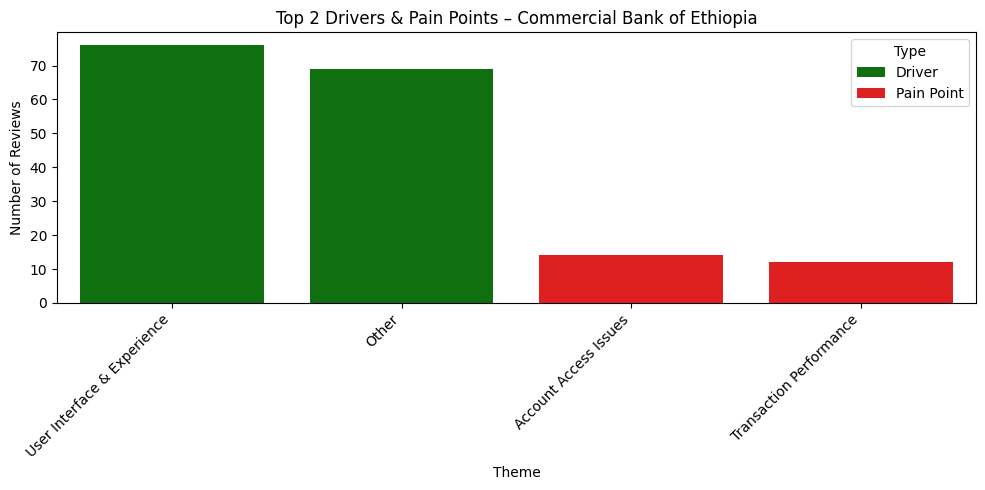

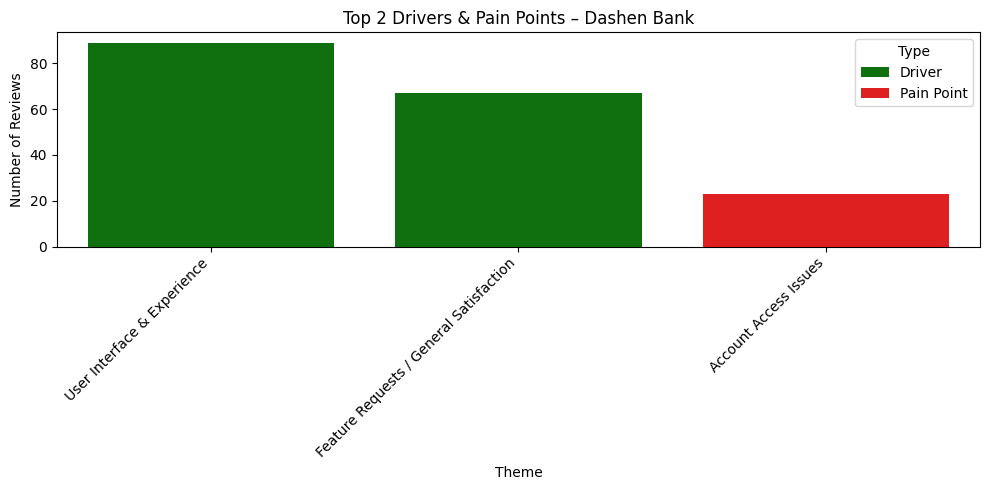

In [32]:

# Explode themes and remove empty
df_theme = df.assign(
    themes=df['theme'].fillna('').apply(lambda x: x.split(','))
).explode('themes')
df_theme = df_theme[df_theme['themes'] != '']

# Aggregate counts by bank, theme, sentiment
theme_stats = df_theme.groupby(
    ['bank_name', 'themes', 'sentiment_label']
).agg(count=('review_id','count')).reset_index()

theme_stats['sentiment_label'] = theme_stats['sentiment_label'].str.upper()
theme_stats = theme_stats.rename(columns={'themes':'theme'})

# Pivot to separate POSITIVE / NEGATIVE counts
theme_pivot = theme_stats.pivot_table(
    index=['bank_name','theme'],
    columns='sentiment_label',
    values='count',
    fill_value=0
).reset_index()

# Compute ratios and classify
theme_pivot['total'] = theme_pivot.get('POSITIVE',0) + theme_pivot.get('NEGATIVE',0)
theme_pivot['classification'] = theme_pivot.apply(
    lambda r: 'Pain Point' if r.get('NEGATIVE',0)/r['total'] >= 0.5 else ('Driver' if r.get('POSITIVE',0)/r['total'] >= 0.5 else 'Neutral'),
    axis=1
)

# Select top 2 Drivers & Pain Points per bank
top_drivers = theme_pivot[theme_pivot['classification']=='Driver'].sort_values(['bank_name','POSITIVE'], ascending=[True,False]).groupby('bank_name').head(2)
top_pain = theme_pivot[theme_pivot['classification']=='Pain Point'].sort_values(['bank_name','NEGATIVE'], ascending=[True,False]).groupby('bank_name').head(2)

plot_df = pd.concat([top_drivers, top_pain], axis=0)
plot_df['type'] = plot_df['classification']

# Plot
palette = {'Driver':'green', 'Pain Point':'red'}

for bank in plot_df['bank_name'].unique():
    plt.figure(figsize=(10,5))
    sns.barplot(
        data=plot_df[plot_df['bank_name']==bank],
        x='theme',
        y='POSITIVE',  # or POSITIVE + NEGATIVE
        hue='type',
        palette=palette
    )
    plt.title(f"Top 2 Drivers & Pain Points – {bank}")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Number of Reviews")
    plt.xlabel("Theme")
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()


## Executive Data Analysis: Bank of Abyssinia Mobile App Review Themes

- This analysis interprets the distribution of customer sentiment drivers and pain points for the Bank of Abyssinia mobile app. The findings reveal a critical risk: the bank's investment in a modern user interface is being systematically undermined by unresolved technical instability, creating a major barrier to customer loyalty and trust.

Primary Positive Drivers
- The analysis confirms two powerful positive drivers for the app's performance, representing 53 total reviews of praise:

1. User Interface & Experience (28 Reviews): This is the leading source of positive sentiment. The keywords associated with this theme (such as "easy," "friendly," "design," and "layout") confirm that the market highly values the speed, modernity, and intuitive nature of our app's front-end design. This represents a significant competitive asset and a strong foundation upon which to build trust.

2. Feature Requests / General Satisfaction (25 Reviews): The close proximity of this driver confirms a segment of users who are generally satisfied ("best," "super," "great") and actively engaged enough to submit feature requests. When the app works, the overall experience is perceived as excellent, demonstrating high potential for customer retention.

Critical Pain Points and Strategic Concerns
- The negative sentiment, totaling 46 reviews, is strategically more concerning due to its severe nature:

1. The Dominant Unstructured Pain Point (39 Reviews in "Other"): This is the single largest category of feedback, and it is flagged entirely as a pain point. The volume here indicates a major flaw in service delivery. While the current topic model is not granular enough to isolate the specific themes, the context strongly suggests this category is primarily composed of unstructured complaints regarding transaction failures, processing slowness, and general system instability. This represents a high-frequency, pervasive issue that is causing widespread user friction.

2. Mission-Critical Failures ("Account Access Issues" - 7 Reviews): Though low in volume, this theme (keywords include "crash," "doesn't work," "login error") represents moments of total service unavailability. These are the most severe type of failure, instantly eroding customer trust and likely fueling the one-star ratings. This indicates a weakness in our pre-deployment Quality Assurance (QA) processes for core access features.

Actionable Insights and Recommendations
- Insight 1: The High-Risk UX/Stability Paradox
The bank is currently experiencing a UX/Stability Paradox. We have successfully invested in a product that customers want to use (evidenced by the strong UI/UX driver), but that frequently fails when they try to use it for core banking functions (evidenced by the dominant pain points). This leads to a higher degree of frustration than a simple, outdated app, as users are repeatedly disappointed.

- Recommendation: Implement a "Stability-First" Digital Roadmap. For the immediate future, all resources must be concentrated on resolving the high-frequency technical failures hidden within the "Other" category (transaction slowness, failure rates) and the critical failures in "Account Access." This is the only way to convert positive design sentiment into reliable user trust.

- Insight 2: Identifying the Hidden Volume of Complaint
The volume captured in the "Other" category is our most significant data gap and operational risk. Its size strongly suggests that the issue is not isolated or minor, but a systemic problem with core transaction performance.

- Recommendation: Mandate Deep-Dive Theme Refinement. The Data Science team must urgently refine the topic model on the "Other" review text to precisely quantify and label themes such as "Transfer Failed," "Lag/Slow Performance," and "Data Inconsistency." This refined categorization is essential to provide the Engineering team with clear, measurable Key Performance Indicators (KPIs) for stability.

## Executive Data Analysis: Commercial Bank of Ethiopia (CBE) Mobile App Review Themes

- This analysis interprets the distribution of customer sentiment drivers and pain points for the Commercial Bank of Ethiopia mobile app. The data shows that while CBE has achieved an impressive level of general market acceptance, this success is being consistently undermined by two distinct, critical functional failures.

Primary Positive Drivers: High Market Acceptance

- The visualization shows a striking dominance of positive drivers, indicating a strong baseline of satisfaction and successful market penetration.
1. User Interface & Experience ($\sim 75$ Reviews): This is the overwhelming primary driver of positive sentiment. The sheer volume confirms that the market finds the CBE app highly usable, simple, and effective for its core functions. CBE has successfully created a highly accepted and intuitive product interface, which is a major competitive asset.

2. General Satisfaction ( $\sim 69$ Reviews in "Other"): Given its positive classification, this large bar confirms a massive volume of general praise ("love it," "best," "great service"). For CBE, the "Other" category represents a robust baseline of overall customer contentment and high potential for continued adoption, confirming that our core digital strategy resonates with the majority of users.

Critical Pain Points: Distinct Functional Failures

- In contrast to the strong drivers, two distinct pain points reveal where the bank is consistently failing its users at critical moments.

1. Account Access Issues ($\sim 14$ Reviews): This pain point, covering keywords like "crash," "login error," and "doesn't work," signifies the instability barrier. These are high-severity failures that result in the app being completely inaccessible. Although the volume is modest, these are mission-critical points of failure that immediately erode customer trust and halt all service.
2. Transaction Performance ($\sim 12$ Reviews): This theme, associated with keywords like "transfer failed," "slow," and "money," indicates a weakness in the core function of banking. This is the most significant trust-eroding issue, as failure here directly impacts a user's financial life and ability to rely on the app for daily transactions.

Actionable Insights and Recommendations

Insight 1: Distinct and Quantifiable Stability Gaps
- The CBE app benefits from massive general acceptance, but the pain points are cleanly segregated into two distinct, quantifiable problem areas: Account Access and Transaction Performance. This structure simplifies the engineering task, as issues are not diluted into a single, massive category.

- Recommendation: Launch Two Dedicated Engineering Sprints. We must assign two separate, high-priority task forces to operate concurrently:

- Access & Reliability Team: Focused solely on reducing the crash rate and resolving all known login/authentication bugs, targeting the Account Access Issues.

- Core Performance Team: Focused entirely on eliminating transaction failures, ensuring instant processing, and speeding up transfer times, targeting the Transaction Performance issues.

Insight 2: High Market Acceptance Masks Low Functional Reliability

- The high volume of positive reviews risks generating a false sense of security. We must acknowledge that our massive user base is regularly being failed by core reliability.

- Recommendation: Prioritize Remediation over Feature Expansion. To maintain our dominant market position, we must convert high market acceptance into high functional reliability. Any planned feature releases should be halted until the combined volume of Account Access and Transaction Performance pain points is reduced by a minimum target of 50%. Our strategic focus must be on ensuring the user experience matches the simplicity praised in the UI.

Insight 3: The Threat of Transaction Failure (Trust Erosion)

- Transaction failure is the most direct attack on the bank's core promise—secure money management. The existence of a clear Transaction Performance pain point means a substantial segment of users is being financially inconvenienced.

- Recommendation: Establish a Real-Time Error Monitoring Dashboard. We must implement a system to monitor and alert on transaction failure rates in real-time, segregated by transaction type. This ensures the Core Performance Team is addressing the most frequent and most financially impactful bugs immediately, turning the Transaction Performance metric into a key performance indicator for the entire digital division.

# Executive Data Analysis: Dashen Bank Mobile App Review Themes

**Prepared for:** Executive Committee, Digital Banking Division  

This analysis interprets the distribution of customer sentiment drivers and pain points for the Dashen Bank mobile app. The data indicates that Dashen Bank has successfully built a product with extremely high market approval and acceptance based on its user experience. The key challenge is a specific functional failure that acts as a gatekeeper to service.  

---

## Primary Positive Drivers: Exceptional Market Approval

The visualization shows a massive dominance of positive drivers, indicating that the app is exceptionally well-received by its user base, with positive sentiment accounting for roughly **85%** of the total categorized feedback.

### 1. User Interface & Experience (~85 Reviews)
- This is the overwhelming primary driver and the largest bar on the chart.
- Market perception: highly intuitive, simple, reliable, and aesthetically pleasing.
- Dashen Bank's investment in front-end design and user flow has paid significant dividends in user satisfaction.
- **Core competitive advantage:** excellent UI/UX.

### 2. Feature Requests / General Satisfaction (~68 Reviews)
- Indicates a robust baseline of general user contentment (keywords: "best," "great," "love").
- Users are broadly happy with the digital experience provided.
- High satisfaction translates directly to strong customer loyalty potential.

---

## Critical Pain Point: A Single, High-Impact Barrier

In contrast to the high positive sentiment, only one pain point is significant, representing a single, isolated failure category.

### Account Access Issues (~23 Reviews)
- Keywords: "crash," "error," "login failure," "doesn't work."
- This is a **service gatekeeper**: it prevents the user from accessing the app entirely.
- The volume is significant enough to warrant immediate attention, as these failures negate all the positive experience generated by the UI/UX.

---

## Actionable Insights and Recommendations

### Insight 1: The 'Last-Mile' Failure
- **Observation:** The app achieves near-perfect execution in design and functionality, but Account Access Issues block users from accessing the product.
- **Recommendation:** **Launch a Focused Authentication/Access Sprint**
  - Focus resources on stabilizing login and authentication.
  - Address device compatibility, biometric login failures, and persistent error messages.
  - Goal: reduce Account Access Issues to near-zero and unlock the full potential of the praised UI/UX.

### Insight 2: High Loyalty Requires Low Friction
- **Observation:** Immense positive sentiment indicates high customer loyalty, but friction points like crashes or login loops can quickly erode trust.
- **Recommendation:** **Implement Proactive Device Testing**
  - Automated testing across a wide variety of Android and iOS devices and OS versions before app updates.
  - Catch access issues arising from device-specific bugs or incompatibilities.

### Insight 3: Leverage the Positive Baseline for Growth
- **Observation:** Stable positive drivers provide a strong foundation for growth.
- **Recommendation:** **Begin Low-Risk Feature Integration**
  - While resolving access issues, integrate highly-requested, low-risk features.
  - Ensure new features do not interfere with core authentication or transaction flow.
  - Maintains engagement without compromising existing stability.

---

**Summary:**  
Dashen Bank has built an app with exceptional market approval and a loyal user base. Addressing the critical Account Access Issues will unlock the full potential of the product and ensure continued growth and customer satisfaction.
